# ThaiNER (LSTM)

using pytorch

from https://github.com/ekapolc/nlp_course/blob/master/PyTorchDemo/pytorch_tute_lstm.ipynb

## Load Data

In [1]:
import dill
with open('datatrain.data', 'rb') as file:
 datatofile = dill.load(file)

In [2]:
datatofile[1]

[('สงสัย', 'NCMN', 'O'),
 ('ติด', 'VACT', 'O'),
 ('หวัด', 'NCMN', 'O'),
 ('นก', 'DDAC', 'O'),
 (' ', 'NCMN', 'O'),
 ('อีก', 'DDBQ', 'O'),
 ('คน', 'NCMN', 'O'),
 ('ยัง', 'XVBM', 'O'),
 ('น่า', 'VSTA', 'O'),
 ('ห่วง', 'NCMN', 'O')]

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
from sklearn.model_selection import cross_validate,train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

print(torch.__version__)

1.0.0


In [4]:
from tqdm import tqdm

In [5]:
USE_CUDA = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [6]:
word_ner=[]
for i in datatofile:
    temp=[]
    for j in i:
        temp.append((j[0],j[2]))
    word_ner.append(temp)

In [7]:
tagged_sents=word_ner

In [8]:
#split data into train set and test set
train_size = int(len(tagged_sents) * 0.8)
train_sents = tagged_sents[:train_size]
test_sents = tagged_sents[train_size:]

In [9]:
train_sents[0]

[('http', 'B-URL'),
 ('://', 'I-URL'),
 ('www', 'I-URL'),
 ('.', 'I-URL'),
 ('bangkokhealth', 'I-URL'),
 ('.', 'I-URL'),
 ('com', 'I-URL'),
 ('/', 'I-URL'),
 ('healthnews', 'I-URL'),
 ('_', 'I-URL'),
 ('htdoc', 'I-URL'),
 ('/', 'I-URL'),
 ('healthnews', 'I-URL'),
 (' ', 'I-URL'),
 ('_', 'I-URL'),
 (' ', 'I-URL'),
 ('detail', 'I-URL'),
 ('.', 'I-URL'),
 ('asp', 'I-URL'),
 ('?', 'I-URL'),
 ('Number', 'I-URL'),
 ('=', 'I-URL'),
 ('10506', 'I-URL')]

## Preparing the Data

In [10]:
word_list=[]
pos_list=[]

for sent in train_sents:
    for word in sent:
        word_list.append(word[0])
        pos_list.append(word[1])


#Word to Index
word_list.append("UNK") #Special Token for unknown words
all_words = sorted(set(word_list))
all_pos = sorted(set(pos_list))
del word_list, pos_list
word_to_ix = dict((c, i) for i, c in enumerate(all_words)) #convert word to index 
pos_to_ix = dict((c, i) for i, c in enumerate(all_pos)) #convert pos to index

In [11]:
print(pos_to_ix) # NER tags

{'B-DATE': 0, 'B-EMAIL': 1, 'B-LAW': 2, 'B-LEN': 3, 'B-LOCATION': 4, 'B-MONEY': 5, 'B-ORGANIZATION': 6, 'B-PERCENT': 7, 'B-PERSON': 8, 'B-PHONE': 9, 'B-TIME': 10, 'B-URL': 11, 'B-ZIP': 12, 'I-DATE': 13, 'I-EMAIL': 14, 'I-LAW': 15, 'I-LEN': 16, 'I-LOCATION': 17, 'I-MONEY': 18, 'I-ORGANIZATION': 19, 'I-PERCENT': 20, 'I-PERSON': 21, 'I-PHONE': 22, 'I-TIME': 23, 'I-URL': 24, 'O': 25}


In [12]:
ix_to_word = dict((v,k) for k,v in word_to_ix.items()) #convert index to word
ix_to_pos = dict((v,k) for k,v in pos_to_ix.items())  #convert index to word

## Preparing the Data for PyTorch

In [13]:
#split each input from its target

input_sent =[ [ word[0] for word in sent]for sent in train_sents ] #words only
train_targets =[ [ word[1] for word in sent]for sent in train_sents ] #POS only

input_test_sent =[ [ word[0] for word in sent]for sent in test_sents ] #words only
test_targets =[ [ word[1] for word in sent]for sent in test_sents ] #POS only
print(input_sent[0], "\n", train_targets[0])

['http', '://', 'www', '.', 'bangkokhealth', '.', 'com', '/', 'healthnews', '_', 'htdoc', '/', 'healthnews', ' ', '_', ' ', 'detail', '.', 'asp', '?', 'Number', '=', '10506'] 
 ['B-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL', 'I-URL']


In [14]:
#Functions for converting input/target text sequences to PyTorch-compatible sequences 

def prepare_sequence_word(input_text):
    """
    Convert an input text sequence for training phrase
    """
    idxs = [word_to_ix[w] for w in input_text]
    tensor = LongTensor(idxs)
    idxs_feat=list()
    for word in input_text:
        if word[0].isupper():
            idxs_feat.append(1)
        else:
            idxs_feat.append(0)

    tensor_cap_feat = LongTensor(idxs_feat)
    return Variable(tensor), tensor_cap_feat

def prepare_sequence_word_test(input_text):
    """
    Convert an input text sequence for testing phrase
    """
    idxs = list()
    for word in input_text:
        if word in word_to_ix:
            idxs.append(word_to_ix[word])
        else:
            idxs.append(word_to_ix["UNK"]) #Use UNK tag for unknown word
   
    tensor = LongTensor(idxs)
    idxs_feat = list()
    for word in input_text:
        if word[0].isupper():
            idxs_feat.append(1)
        else:
            idxs_feat.append(0)

    tensor_cap_feat = LongTensor(idxs_feat)
    return Variable(tensor, volatile=True), tensor_cap_feat

def prepare_sequence_target_pos(input_label):
    """
    Convert an input target sequence for training phrase
    """
    idxs = [pos_to_ix[w] for w in input_label]
    tensor = LongTensor(idxs)
    return Variable(tensor)

In [15]:
print(prepare_sequence_word(input_sent[0]))
print(input_sent[0])

(tensor([1671, 1072, 1767,   59, 1630,   59, 1646,   70, 1668, 1620, 1670,   70,
        1668,    0, 1620,    0, 1653,   59, 1628, 1076, 1417, 1073,  260],
       device='cuda:0'), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       device='cuda:0'))
['http', '://', 'www', '.', 'bangkokhealth', '.', 'com', '/', 'healthnews', '_', 'htdoc', '/', 'healthnews', ' ', '_', ' ', 'detail', '.', 'asp', '?', 'Number', '=', '10506']


In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, word_emb_dim , hidden_dim, output_size):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim

        self.word_embedding = nn.Embedding(input_size, word_emb_dim)

        ################################################################
        self.i2ig = nn.Linear(word_emb_dim, hidden_dim) #normal inputgate
        self.h2ig = nn.Linear(hidden_dim, hidden_dim) #normal inputgate
        
        self.i2ig_cap = nn.Linear(word_emb_dim, hidden_dim) #inputgate for capitalized word
        self.h2ig_cap = nn.Linear(hidden_dim, hidden_dim) #inputgate for capitalized word
        #####################################################################
        self.i2ctil = nn.Linear(word_emb_dim, hidden_dim) #c_tilde (new memory cell)
        self.h2ctil = nn.Linear(hidden_dim, hidden_dim) #c_tilde (new memory cell)
        
        self.i2fg = nn.Linear(word_emb_dim, hidden_dim) #forgetgate
        self.h2fg = nn.Linear(hidden_dim, hidden_dim) #forgetgate
        
        self.i2og = nn.Linear(word_emb_dim, hidden_dim) #outputgate
        self.h2og = nn.Linear(hidden_dim, hidden_dim) #outputgate
        
        self.hidden2tag = nn.Linear(hidden_dim, output_size) #output
        self.softmax = nn.LogSoftmax()
        
        
    def _inputGate(self, word_embed, hidden):
        """
        input gate: how much the current input matters according to the past hidden state 
        and the current input
        """
        i_t = F.sigmoid(self.i2ig(word_embed)+self.h2ig(hidden))
        return i_t
    
    def _inputGateCap(self, word_embed, hidden):
        """
        input gate for a capitalized word
        """
        i_t = F.sigmoid(self.i2ig_cap(word_embed)+self.h2ig_cap(hidden))
        return i_t
                        
    def _newMemoryCell(self, word_embed, hidden):
        """
        New memory cell: how much the current input will be remembered according to the past hidden state 
        and the current input 
        """
        c_tilda = F.tanh(self.i2ctil(word_embed)+self.h2ctil(hidden)) #new memory cell
        return c_tilda
    
    def _forgetGate(self, word_embed, hidden):
        """
        Forget gate: how much the past memory cell matters according to the past hidden state 
        and the current input
        """
        f_t = F.sigmoid(self.i2fg(word_embed)+self.h2fg(hidden))#forget gate
        return f_t
    
    def _cellState(self,c_prev,c_tilda,f_t,i_t):
        """
        Final memory cell: Decide how much the past memory cell will be forgotten according to the forget gate
        and decide how much the new memory cell matters according to the input gate. 
        Then it sums both decisions to generate the final memory cell (c_t)
        """
        c_t = (f_t * c_prev) + (i_t * c_tilda) 
        return c_t
    
    def _outputGate(self, word_embed, hidden, c_t):
        
        """
        Output gate: calculate the final hidden state according to the current input, the past hidden state
        , and the final memory cell
        """
        o_t =   F.sigmoid(self.i2og(word_embed)+self.h2og(hidden))
        h_t  =  o_t * F.tanh(c_t)
        return h_t 

    def forward(self, input_word, hidden, c_prev,feat):
   
        word_embed = self.word_embedding(input_word)
        f_t = self._forgetGate(word_embed, hidden)
        
        
        if feat==0:
            i_t = self._inputGate(word_embed, hidden)
        elif feat==1:
            i_t = self._inputGateCap(word_embed, hidden)
            
        c_tilde = self._newMemoryCell(word_embed, hidden)
        c_t = self._cellState(c_prev, c_tilde, f_t, i_t)#final memory cell
        h_t = self._outputGate(word_embed, hidden,c_t)#final hidden state
        lstm_out = self.hidden2tag(h_t)
        output = self.softmax(lstm_out)
        return output, h_t, c_t

    def initHidden(self):
        init_zeros = torch.zeros(1, self.hidden_dim).cuda() if USE_CUDA else torch.zeros(1, self.hidden_dim)
        return Variable(init_zeros)
    
    def initCellState(self):
        init_zeros = torch.zeros(1, self.hidden_dim).cuda() if USE_CUDA else torch.zeros(1, self.hidden_dim)
        return Variable(init_zeros)
#Initialization    
n_words = len(word_to_ix) #number of unique words
n_hidden = 128 # number of hidden dimensions
n_emb_dim = 64 # number of word vector dimension
n_categories = len(pos_to_ix) # number of POS categories
lstm = LSTM(n_words, n_emb_dim, n_hidden, n_categories) #initilize the model
if USE_CUDA:
    lstm = lstm.cuda()

In [17]:
criterion = nn.NLLLoss() #Last layer is nn.LogSoftMax, therefore NLLLoss is suitable
learning_rate = 0.001
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) #ADAM OPTIMIZER

def train(category_tensor, sentence_tensor,feat_tensor,train=True):
    if train:
        lstm.train(True)
    else:
        lstm.eval()
    hidden = lstm.initHidden() #initialize hidden state
    cell_state = lstm.initCellState() #initiailze cell state
    lstm.zero_grad()# reset gradient to zero

    for i in range(sentence_tensor.size()[0]): # for each word in a sentence
        output, hidden, cell_state = lstm(sentence_tensor[i], hidden,cell_state,feat_tensor[i])#fwd
        if i != 0:
            all_outputs=torch.cat((all_outputs,output),0) #concat output vectors together to calculate loss in one go
        else:
            all_outputs=output

    loss = criterion(all_outputs, category_tensor)# calculate loss
    if train:
        loss.backward()#backprop
        optimizer.step()#update parameters
    return all_outputs, loss.item()

In [18]:
import time
import math

n_iters = 20
print_every = 1

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
train_losses=[]
val_losses=[]
for iter in range(1, n_iters + 1):#Epoch
    loader = tqdm(zip(input_sent,train_targets), total=len(input_sent))
    for sentence, pos_tags in loader: #Sentence
        sentence_tensor, feat_tensor = prepare_sequence_word(sentence) #preprocess input
        category_tensor = prepare_sequence_target_pos(pos_tags) #preprocess tags
        output, loss = train(category_tensor, sentence_tensor, feat_tensor) #fwd
    loader = tqdm(zip(input_sent,train_targets), total=len(input_sent))
    for sentence, pos_tags in loader: #Sentence
        sentence_tensor, feat_tensor = prepare_sequence_word(sentence) #preprocess input
        category_tensor = prepare_sequence_target_pos(pos_tags) #preprocess tags
        output, val_loss = train(category_tensor, sentence_tensor, feat_tensor,train=False) #fwd
    # Print iter number,time, loss
    if iter % print_every == 0:
        print('ep %d %d%% (%s) loss %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))
        print('val loss %.4f ' % (val_loss))
        train_losses.append(loss)
        val_losses.append(val_loss)
        torch.save(lstm.state_dict(), "ner-lstm.pt.ep"+str(iter))

  0%|          | 0/4918 [00:00<?, ?it/s]/home/wannaphong/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/wannaphong/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 3/4918 [00:00<03:23, 24.10it/s]

ep 1 5% (8m 26s) loss 0.7908 
val loss 0.6936 


  0%|          | 3/4918 [00:00<03:21, 24.37it/s]

ep 2 10% (16m 49s) loss 0.2332 
val loss 0.1349 


  0%|          | 3/4918 [00:00<03:35, 22.85it/s]

ep 3 15% (25m 14s) loss 0.2900 
val loss 0.1648 


  0%|          | 3/4918 [00:00<03:30, 23.30it/s]

ep 4 20% (33m 34s) loss 0.0146 
val loss 0.0134 


  0%|          | 3/4918 [00:00<03:30, 23.36it/s]

ep 5 25% (41m 53s) loss 0.0181 
val loss 0.0136 


  0%|          | 3/4918 [00:00<03:28, 23.54it/s]

ep 6 30% (50m 12s) loss 0.0484 
val loss 0.0036 


  0%|          | 3/4918 [00:00<03:30, 23.33it/s]

ep 7 35% (58m 31s) loss 0.3861 
val loss 0.0322 


  0%|          | 3/4918 [00:00<03:26, 23.83it/s]

ep 8 40% (66m 50s) loss 0.0004 
val loss 0.0004 


  0%|          | 3/4918 [00:00<03:24, 24.03it/s]

ep 9 45% (75m 10s) loss 0.0005 
val loss 0.0005 


  0%|          | 3/4918 [00:00<03:23, 24.13it/s]

ep 10 50% (83m 29s) loss 0.0009 
val loss 0.0008 


  0%|          | 3/4918 [00:00<03:41, 22.19it/s]

ep 11 55% (91m 48s) loss 0.0003 
val loss 0.0003 


  0%|          | 3/4918 [00:00<03:30, 23.33it/s]

ep 12 60% (100m 7s) loss 0.0004 
val loss 0.0004 


  0%|          | 3/4918 [00:00<03:33, 23.04it/s]

ep 13 65% (108m 26s) loss 0.0008 
val loss 0.0007 


  0%|          | 3/4918 [00:00<03:36, 22.71it/s]

ep 14 70% (116m 46s) loss 0.0003 
val loss 0.0003 


  0%|          | 3/4918 [00:00<03:32, 23.08it/s]

ep 15 75% (125m 5s) loss 0.0012 
val loss 0.0009 


  0%|          | 3/4918 [00:00<03:19, 24.60it/s]

ep 16 80% (133m 25s) loss 0.0003 
val loss 0.0003 


  0%|          | 3/4918 [00:00<03:20, 24.55it/s]

ep 17 85% (141m 44s) loss 0.0002 
val loss 0.0002 


  0%|          | 3/4918 [00:00<03:26, 23.75it/s]

ep 18 90% (150m 4s) loss 0.0003 
val loss 0.0003 


  0%|          | 3/4918 [00:00<03:25, 23.92it/s]

ep 19 95% (158m 23s) loss 0.0001 
val loss 0.0001 


100%|██████████| 4918/4918 [02:36<00:00, 31.52it/s] 

ep 20 100% (166m 42s) loss 0.0001 
val loss 0.0001 


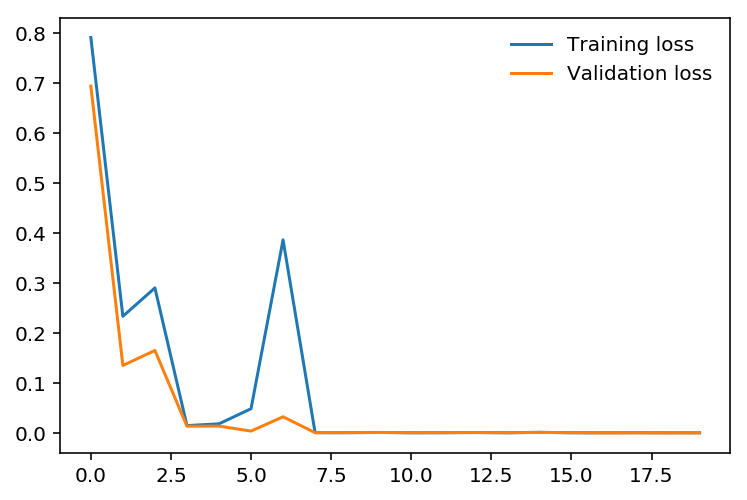

In [19]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [20]:
def predict(input_sent):
    y_pred=[]
    lstm.train(False)
    hidden = lstm.initHidden()
    cell_state = lstm.initCellState()
    sentence_tensor, feat_tensor = prepare_sequence_word_test(input_sent)
    for i in range(sentence_tensor.size()[0]):
        output, hidden, cell_state = lstm(sentence_tensor[i], hidden,cell_state,feat_tensor[i] )
        output=output[0].data.tolist()
        out_ix=output.index(max(output))
        y_pred.append(ix_to_pos[out_ix])
    
    return y_pred

In [23]:
print(predict(input_test_sent[1]))
print(input_test_sent[1])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-LOCATION', 'I-ORGANIZATION', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'I-DATE', 'O']
['“', 'ระบบ', 'โซ', 'ตัส', 'ที่', 'ใหญ่', 'ที่สุด', ' ', 'ไม่ใช่', 'อยู่', 'ใน', 'มหาวิทยาลัย', ' ', 'ทหาร', ' ', 'เอา', 'ที่จริง', 'มีระบบ', 'ใหญ่', 'กว่า', 'นั้น', 'แต่', 'อำนาจ', 'ไม่', 'แรง', ' ', 'ระบบ', 'ราชการ', 'ทั้งหมด', 'เลย', ' ', 'โซ', 'ตัส', 'ใน', 'มหาวิทยาลัย', 'มัน', 'กระจอก', '”', ' ', 'ศาสตราจารย์', 'กิตติคุณ', 'ธงชัย', 'กล่าว', 'ใน', 'งาน', 'เสวนา', 'บันทึก', 'ข้อมูล', 'เพื่อ', 'ทวง', 'ความยุติธรรม', 'จัด', 'โดย', 'สโมสร', 'นิสิต', 'คณะรัฐศาสตร์', ' ', 'จุฬา',

/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [24]:
test_sents[1]

[('“', 'O'),
 ('ระบบ', 'O'),
 ('โซ', 'O'),
 ('ตัส', 'O'),
 ('ที่', 'O'),
 ('ใหญ่', 'O'),
 ('ที่สุด', 'O'),
 (' ', 'O'),
 ('ไม่ใช่', 'O'),
 ('อยู่', 'O'),
 ('ใน', 'O'),
 ('มหาวิทยาลัย', 'O'),
 (' ', 'O'),
 ('ทหาร', 'O'),
 (' ', 'O'),
 ('เอา', 'O'),
 ('ที่จริง', 'O'),
 ('มีระบบ', 'O'),
 ('ใหญ่', 'O'),
 ('กว่า', 'O'),
 ('นั้น', 'O'),
 ('แต่', 'O'),
 ('อำนาจ', 'O'),
 ('ไม่', 'O'),
 ('แรง', 'O'),
 (' ', 'O'),
 ('ระบบ', 'O'),
 ('ราชการ', 'O'),
 ('ทั้งหมด', 'O'),
 ('เลย', 'O'),
 (' ', 'O'),
 ('โซ', 'O'),
 ('ตัส', 'O'),
 ('ใน', 'O'),
 ('มหาวิทยาลัย', 'O'),
 ('มัน', 'O'),
 ('กระจอก', 'O'),
 ('”', 'O'),
 (' ', 'O'),
 ('ศาสตราจารย์', 'B-PERSON'),
 ('กิตติคุณ', 'I-PERSON'),
 ('ธงชัย', 'I-PERSON'),
 ('กล่าว', 'O'),
 ('ใน', 'O'),
 ('งาน', 'O'),
 ('เสวนา', 'O'),
 ('บันทึก', 'O'),
 ('ข้อมูล', 'O'),
 ('เพื่อ', 'O'),
 ('ทวง', 'O'),
 ('ความยุติธรรม', 'O'),
 ('จัด', 'O'),
 ('โดย', 'O'),
 ('สโมสร', 'B-ORGANIZATION'),
 ('นิสิต', 'I-ORGANIZATION'),
 ('คณะรัฐศาสตร์', 'I-ORGANIZATION'),
 (' ', 'O'),
 ('จุฬา', 

In [25]:
#predict POS tags for all sentences in the testset
y_pred = []

for test_sent in input_test_sent:
    temp_pred = predict(test_sent)
    y_pred.append(temp_pred)

/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [37]:
def pos_classification_report(y_true, y_pred):
 
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
    tagset = list(sorted(set(lb.classes_)))
    print(tagset)
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset if cls!="O"],
        target_names = tagset,
        digits=4
    )

In [38]:
print(pos_classification_report(test_targets,y_pred))

['B-DATE', 'B-LAW', 'B-LEN', 'B-LOCATION', 'B-MONEY', 'B-ORGANIZATION', 'B-PERCENT', 'B-PERSON', 'B-PHONE', 'B-TIME', 'B-URL', 'I-DATE', 'I-LAW', 'I-LEN', 'I-LOCATION', 'I-MONEY', 'I-ORGANIZATION', 'I-PERCENT', 'I-PERSON', 'I-PHONE', 'I-TIME', 'I-URL', 'O']
                precision    recall  f1-score   support

        B-DATE     0.8329    0.7429    0.7853       389
         B-LAW     0.7692    0.5000    0.6061        80
         B-LEN     0.1250    0.1818    0.1481        11
    B-LOCATION     0.7391    0.6847    0.7108       666
       B-MONEY     0.5565    0.5111    0.5328       135
B-ORGANIZATION     0.7038    0.7311    0.7172      1365
     B-PERCENT     0.4444    0.2105    0.2857        19
      B-PERSON     0.8746    0.7630    0.8150       713
       B-PHONE     0.3750    0.6000    0.4615         5
        B-TIME     0.4878    0.4211    0.4520        95
         B-URL     0.8000    0.9231    0.8571        13
        I-DATE     0.8627    0.7516    0.8034       761
         I-LA

/home/wannaphong/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1537: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))
/home/wannaphong/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/wannaphong/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [39]:
predict(["ผม","ชื่อ","นาย","บุญ","มาก"," ","ทอง","ดี"])

/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/wannaphong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


['O',
 'O',
 'B-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON',
 'I-PERSON']

In [40]:
len(word_to_ix)

12739

In [41]:
import dill
with open('word_to_ix.pkl', 'wb') as file:
    dill.dump(word_to_ix, file)

In [42]:
with open('pos_to_ix.pkl', 'wb') as file:
    dill.dump(pos_to_ix, file)